Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 13.9 MB/s 
     |████████████████████████████████| 101 kB 11.6 MB/s 
     |████████████████████████████████| 6.6 MB 79.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a66808a66399f0e1e10439b64a9f0389e9f159ee3341007a756522305d9fa3ad
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['O', 'I-Disease', 'B-Chemical', 'I-Chemical', 'B-Disease']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['O', 'I-Disease', 'B-Chemical', 'I-Chemical', 'B-Disease']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['O', 'I-Disease', 'B-Chemical', 'I-Chemical', 'B-Disease']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

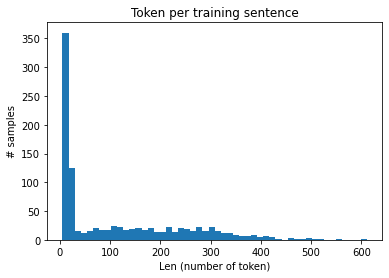

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

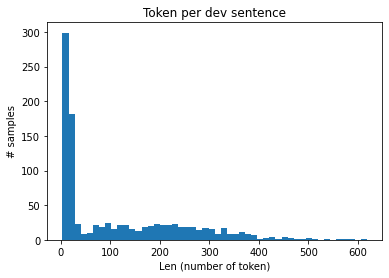

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

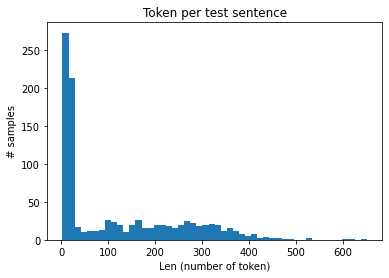

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'incidence'
print(word2idx['incidence'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Disease'
print(tag2idx['B-Disease'])
# Tag of index 4
print(idx2tag[4])

3970
brush
4
B-Disease


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.25)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 750
Points in y_train before removal: 750


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[38, 9828, 11595, 17260, 14340, 11382, 2719, 4418, 332, 3312, 5556, 13073]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[8046, 10853, 15408, 11382, 4005, 1023, 5556, 17246, 17691, 8789, 11038, 13073]
[4, 1, 1, 0, 2, 3, 4, 0, 0, 0, 0, 0]
[13907, 8259, 12121, 18312, 13073, 8814, 9754, 9828, 232, 14415, 13073]
[2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0]
3970
4
B-Chemical
View
18533
5


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.7 MB/s 
     |████████████████████████████████| 120 kB 91.5 MB/s 
     |████████████████████████████████| 6.6 MB 68.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=27ae497263a45ca865a131f32e8467112d54ad977cad343c6348419d5990fe24
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[38, 9828, 11595, 17260, 14340, 11382, 2719, 4418, 332, 33

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5168120861053467
Training loss epoch: 0.2320609750582817
Training accuracy epoch: 0.9276545492972944
Validating model...
Validation Loss: 0.08888533468993884
Validation Accuracy: 0.9701949475003883
Training epoch: 2
Training loss per 100 training steps: 0.05515306442975998
Training loss epoch: 0.06820952559405184
Training accuracy epoch: 0.9783949089775765
Validating model...
Validation Loss: 0.07378493001063664
Validation Accuracy: 0.9752260674224069
Training epoch: 3
Training loss per 100 training steps: 0.03921939432621002
Training loss epoch: 0.03692165510530802
Training accuracy epoch: 0.9885150816154226
Validating model...
Validation Loss: 0.07955950235445348
Validation Accuracy: 0.9746626438776324
Training epoch: 4
Training loss per 100 training steps: 0.02979535609483719
Training loss epoch: 0.021225830282461135
Training accuracy epoch: 0.9931094347850652
Validating model...
Validation Loss: 0.07992105387032979
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07915441508567522
Validation Accuracy: 0.9736140821083414
Validation duration: 0.23715238333333274 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

    Chemical       0.88      0.93      0.90      4985
     Disease       0.73      0.84      0.78      4416

   micro avg       0.81      0.88      0.84      9401
   macro avg       0.80      0.88      0.84      9401
weighted avg       0.81      0.88      0.84      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7824907302856445
Training loss epoch: 0.23836834538490215
Training accuracy epoch: 0.9256517303921143
Validating model...
Validation Loss: 0.08763293383849992
Validation Accuracy: 0.970131979427319
Training epoch: 2
Training loss per 100 training steps: 0.07721634209156036
Training loss epoch: 0.06747177591983308
Training accuracy epoch: 0.977772454191502
Validating model...
Validation Loss: 0.07976548840838765
Validation Accuracy: 0.9719707252677943
Training epoch: 3
Training loss per 100 training steps: 0.03228672221302986
Training loss epoch: 0.03780572138171881
Training accuracy epoch: 0.9882682393257085
Validating model...
Validation Loss: 0.07442526838609151
Validation Accuracy: 0.9761446493463299
Training epoch: 4
Training loss per 100 training steps: 0.017617937177419662
Training loss epoch: 0.02048296612152394
Training accuracy epoch: 0.9936550863756484
Validating model...
Validation Loss: 0.0811018432889666
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0789008763810945
Validation Accuracy: 0.9758704564983094
Validation duration: 0.2359712000000002 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.7%
              precision    recall  f1-score   support

    Chemical       0.92      0.92      0.92      4985
     Disease       0.76      0.82      0.79      4416

   micro avg       0.84      0.87      0.86      9401
   macro avg       0.84      0.87      0.85      9401
weighted avg       0.84      0.87      0.86      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1754558086395264
Training loss epoch: 0.2804487162130944
Training accuracy epoch: 0.9152730202994667
Validating model...
Validation Loss: 0.08881660290653744
Validation Accuracy: 0.9705136531266844
Training epoch: 2
Training loss per 100 training steps: 0.08423154056072235
Training loss epoch: 0.0737355387908347
Training accuracy epoch: 0.9760752217518329
Validating model...
Validation Loss: 0.07237798194327051
Validation Accuracy: 0.9753169853784215
Training epoch: 3
Training loss per 100 training steps: 0.04368968307971954
Training loss epoch: 0.03925109940006378
Training accuracy epoch: 0.9877237008308759
Validating model...
Validation Loss: 0.07599293127182931
Validation Accuracy: 0.9758022489499527
Training epoch: 4
Training loss per 100 training steps: 0.028668226674199104
Training loss epoch: 0.021343293966368793
Training accuracy epoch: 0.9933857141539235
Validating model...
Validation Loss: 0.07657110117494113
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0766377593908045
Validation Accuracy: 0.9739516080755334
Validation duration: 0.2386330833333337 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.0%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.76      0.80      0.78      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.83      0.86      0.85      9401
weighted avg       0.84      0.87      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7381372451782227
Training loss epoch: 0.24137962451006503
Training accuracy epoch: 0.9257237713285579
Validating model...
Validation Loss: 0.08758733013556116
Validation Accuracy: 0.9699534079455411
Training epoch: 2
Training loss per 100 training steps: 0.08403175324201584
Training loss epoch: 0.0676853217263805
Training accuracy epoch: 0.977876854413866
Validating model...
Validation Loss: 0.07411955965180246
Validation Accuracy: 0.9746956630110511
Training epoch: 3
Training loss per 100 training steps: 0.038343645632267
Training loss epoch: 0.03746334560453258
Training accuracy epoch: 0.9883575578849432
Validating model...
Validation Loss: 0.07095595614777671
Validation Accuracy: 0.9775048832707949
Training epoch: 4
Training loss per 100 training steps: 0.013719618320465088
Training loss epoch: 0.019477431929888243
Training accuracy epoch: 0.9941228881112549
Validating model...
Validation Loss: 0.07679661650151487
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07745692577390444
Validation Accuracy: 0.9747819040882167
Validation duration: 0.23716563333333623 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.91      4985
     Disease       0.75      0.82      0.79      4416

   micro avg       0.84      0.87      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.84      0.87      0.85      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5480892658233643
Training loss epoch: 0.23372415072740393
Training accuracy epoch: 0.9270023246618603
Validating model...
Validation Loss: 0.10109105587951721
Validation Accuracy: 0.9637071435693311
Training epoch: 2
Training loss per 100 training steps: 0.08478143066167831
Training loss epoch: 0.07003759259873248
Training accuracy epoch: 0.9777471560745059
Validating model...
Validation Loss: 0.0764829929740656
Validation Accuracy: 0.9727579521778926
Training epoch: 3
Training loss per 100 training steps: 0.038486238569021225
Training loss epoch: 0.04021116936618977
Training accuracy epoch: 0.9869801349740716
Validating model...
Validation Loss: 0.07288877769476837
Validation Accuracy: 0.9760297800493734
Training epoch: 4
Training loss per 100 training steps: 0.010443492792546749
Training loss epoch: 0.02253032642159056
Training accuracy epoch: 0.9927252613922829
Validating model...
Validation Loss: 0.0820399085207591
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07718416451225205
Validation Accuracy: 0.9752523772319773
Validation duration: 0.2368868333333315 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.93      0.89      0.91      4985
     Disease       0.76      0.83      0.79      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.85      0.86      0.85      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8876762390136719
Training loss epoch: 0.24046600245414895
Training accuracy epoch: 0.9235181241731125
Validating model...
Validation Loss: 0.0884929197056899
Validation Accuracy: 0.9695063423005341
Training epoch: 2
Training loss per 100 training steps: 0.046810612082481384
Training loss epoch: 0.07092759789938623
Training accuracy epoch: 0.9774090519707946
Validating model...
Validation Loss: 0.07369484888419273
Validation Accuracy: 0.9748848203890881
Training epoch: 3
Training loss per 100 training steps: 0.0470571294426918
Training loss epoch: 0.04066064339527424
Training accuracy epoch: 0.9871565223013525
Validating model...
Validation Loss: 0.07232883933281141
Validation Accuracy: 0.9768263676916046
Training epoch: 4
Training loss per 100 training steps: 0.017381783574819565
Training loss epoch: 0.021830280073621172
Training accuracy epoch: 0.9931062308032608
Validating model...
Validation Loss: 0.08117204212716647
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0742589080972331
Validation Accuracy: 0.9765404586259503
Validation duration: 0.2351897000000008 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.6%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.92      4985
     Disease       0.77      0.82      0.79      4416

   micro avg       0.85      0.86      0.86      9401
   macro avg       0.85      0.86      0.85      9401
weighted avg       0.86      0.86      0.86      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5163227319717407
Training loss epoch: 0.22496235552937427
Training accuracy epoch: 0.9301711085653783
Validating model...
Validation Loss: 0.08579887721746687
Validation Accuracy: 0.9713932536086303
Training epoch: 2
Training loss per 100 training steps: 0.13166454434394836
Training loss epoch: 0.0665787548777905
Training accuracy epoch: 0.978552903181551
Validating model...
Validation Loss: 0.07130235528189038
Validation Accuracy: 0.9762308669141688
Training epoch: 3
Training loss per 100 training steps: 0.021389968693256378
Training loss epoch: 0.03411227563752773
Training accuracy epoch: 0.988970165403274
Validating model...
Validation Loss: 0.07393081166914531
Validation Accuracy: 0.9759625008579395
Training epoch: 4
Training loss per 100 training steps: 0.019808579236268997
Training loss epoch: 0.020622917985979546
Training accuracy epoch: 0.9937623996723701
Validating model...
Validation Loss: 0.08457412020791144
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07269218392551892
Validation Accuracy: 0.9755233826980297
Validation duration: 0.2382402333333327 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.5%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.91      4985
     Disease       0.75      0.80      0.77      4416

   micro avg       0.84      0.85      0.85      9401
   macro avg       0.84      0.85      0.84      9401
weighted avg       0.84      0.85      0.85      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8746724128723145
Training loss epoch: 0.24301998023974133
Training accuracy epoch: 0.9234648976876648
Validating model...
Validation Loss: 0.09323957787146644
Validation Accuracy: 0.9678388671386267
Training epoch: 2
Training loss per 100 training steps: 0.08783406764268875
Training loss epoch: 0.07059331444349695
Training accuracy epoch: 0.9778007782672801
Validating model...
Validation Loss: 0.07664754667452403
Validation Accuracy: 0.9739193778330455
Training epoch: 3
Training loss per 100 training steps: 0.06977084279060364
Training loss epoch: 0.04085371417409562
Training accuracy epoch: 0.9874421265946847
Validating model...
Validation Loss: 0.0753923152824716
Validation Accuracy: 0.9768382350782828
Training epoch: 4
Training loss per 100 training steps: 0.01852416805922985
Training loss epoch: 0.024164836437619748
Training accuracy epoch: 0.9924558833059598
Validating model...
Validation Loss: 0.08062100652900953
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07800846570540988
Validation Accuracy: 0.9756392435025283
Validation duration: 0.2370844833333346 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.4%
              precision    recall  f1-score   support

    Chemical       0.88      0.95      0.91      4985
     Disease       0.76      0.81      0.79      4416

   micro avg       0.82      0.89      0.85      9401
   macro avg       0.82      0.88      0.85      9401
weighted avg       0.82      0.89      0.85      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5212794542312622
Training loss epoch: 0.22385996706942293
Training accuracy epoch: 0.9314838290128126
Validating model...
Validation Loss: 0.08848796885401483
Validation Accuracy: 0.9700148021126931
Training epoch: 2
Training loss per 100 training steps: 0.06653036922216415
Training loss epoch: 0.06518056576556348
Training accuracy epoch: 0.9789606259184153
Validating model...
Validation Loss: 0.07057127539837171
Validation Accuracy: 0.976615474398743
Training epoch: 3
Training loss per 100 training steps: 0.04977820813655853
Training loss epoch: 0.039542906105201295
Training accuracy epoch: 0.987031397465388
Validating model...
Validation Loss: 0.08581953584438279
Validation Accuracy: 0.972903603465627
Training epoch: 4
Training loss per 100 training steps: 0.03870094195008278
Training loss epoch: 0.02116288188250458
Training accuracy epoch: 0.9932061892605144
Validating model...
Validation Loss: 0.09376794566947316
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07254923306523807
Validation Accuracy: 0.9753860750958222
Validation duration: 0.23606339999999668 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.1%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.77      0.80      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.84      0.86      0.85      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 750
Points in y_train after augmentation: 750
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5632930994033813
Training loss epoch: 0.23871521429812653
Training accuracy epoch: 0.9283276163866832
Validating model...
Validation Loss: 0.08563565959533055
Validation Accuracy: 0.9711718319928685
Training epoch: 2
Training loss per 100 training steps: 0.05624740198254585
Training loss epoch: 0.06653869778234908
Training accuracy epoch: 0.979103049713558
Validating model...
Validation Loss: 0.07112762645360023
Validation Accuracy: 0.9760810483559034
Training epoch: 3
Training loss per 100 training steps: 0.04321293905377388
Training loss epoch: 0.038927536101100293
Training accuracy epoch: 0.987391220968675
Validating model...
Validation Loss: 0.07386215362283918
Validation Accuracy: 0.976693426819536
Training epoch: 4
Training loss per 100 training steps: 0.009491664357483387
Training loss epoch: 0.023895521083490013
Training accuracy epoch: 0.9924044728834117
Validating model...
Validation Loss: 0.07608899530318994
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07193115755679115
Validation Accuracy: 0.9754953409689231
Validation duration: 0.23991439999999783 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.1%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.91      4985
     Disease       0.78      0.78      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.84      0.85      0.85      9401
weighted avg       0.84      0.86      0.85      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6219218969345093
Training loss epoch: 0.20381249436887644
Training accuracy epoch: 0.9359178531341455
Validating model...
Validation Loss: 0.08268727953471834
Validation Accuracy: 0.9710857646993734
Training epoch: 2
Training loss per 100 training steps: 0.07775814831256866
Training loss epoch: 0.05688908633034108
Training accuracy epoch: 0.9818770022414122
Validating model...
Validation Loss: 0.07716572757751222
Validation Accuracy: 0.9742706884181512
Training epoch: 3
Training loss per 100 training steps: 0.029052598401904106
Training loss epoch: 0.03230892434337382
Training accuracy epoch: 0.9897835211053125
Validating model...
Validation Loss: 0.07791832923179581
Validation Accuracy: 0.9760061812249404
Training epoch: 4
Training loss per 100 training steps: 0.01906403712928295
Training loss epoch: 0.016634324462926488
Training accuracy epoch: 0.9946263251534576
Validating model...
Validation Loss: 0.08731677353618637
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07518439692637277
Validation Accuracy: 0.9750741622875265
Validation duration: 0.2372080833333333 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.9%
              precision    recall  f1-score   support

    Chemical       0.90      0.94      0.92      4985
     Disease       0.76      0.78      0.77      4416

   micro avg       0.83      0.86      0.85      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8791638612747192
Training loss epoch: 0.22515771335969537
Training accuracy epoch: 0.9301121350439506
Validating model...
Validation Loss: 0.08416422539287144
Validation Accuracy: 0.9717642531457807
Training epoch: 2
Training loss per 100 training steps: 0.05697811767458916
Training loss epoch: 0.06291242325836319
Training accuracy epoch: 0.9797498717419616
Validating model...
Validation Loss: 0.07538273871418029
Validation Accuracy: 0.9747265582196848
Training epoch: 3
Training loss per 100 training steps: 0.020684637129306793
Training loss epoch: 0.034574359087115626
Training accuracy epoch: 0.9894782015014655
Validating model...
Validation Loss: 0.07559137599217514
Validation Accuracy: 0.9759407367406884
Training epoch: 4
Training loss per 100 training steps: 0.013652252033352852
Training loss epoch: 0.018143603270399874
Training accuracy epoch: 0.9944934778010984
Validating model...
Validation Loss: 0.08820931583879486
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07545743521953387
Validation Accuracy: 0.9748745449213501
Validation duration: 0.23789710000000167 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.8%
              precision    recall  f1-score   support

    Chemical       0.93      0.89      0.91      4985
     Disease       0.78      0.79      0.78      4416

   micro avg       0.86      0.84      0.85      9401
   macro avg       0.85      0.84      0.85      9401
weighted avg       0.86      0.84      0.85      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3128535747528076
Training loss epoch: 0.19791238224607402
Training accuracy epoch: 0.9387043356576356
Validating model...
Validation Loss: 0.08125568683894854
Validation Accuracy: 0.972191548533113
Training epoch: 2
Training loss per 100 training steps: 0.06603515148162842
Training loss epoch: 0.06264718972399073
Training accuracy epoch: 0.9801823611394298
Validating model...
Validation Loss: 0.07618182400862376
Validation Accuracy: 0.9742603265951917
Training epoch: 3
Training loss per 100 training steps: 0.028112895786762238
Training loss epoch: 0.033355955476477996
Training accuracy epoch: 0.9894512575183094
Validating model...
Validation Loss: 0.07540320741042258
Validation Accuracy: 0.974651712658992
Training epoch: 4
Training loss per 100 training steps: 0.020914994180202484
Training loss epoch: 0.02038110411426021
Training accuracy epoch: 0.993959312315742
Validating model...
Validation Loss: 0.08039063404476832
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08295458620266309
Validation Accuracy: 0.9735770688822971
Validation duration: 0.23439830000000558 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.72      0.84      0.77      4416

   micro avg       0.81      0.89      0.84      9401
   macro avg       0.80      0.88      0.84      9401
weighted avg       0.81      0.89      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7191931009292603
Training loss epoch: 0.21344790531922195
Training accuracy epoch: 0.9314149558804069
Validating model...
Validation Loss: 0.08491763247857018
Validation Accuracy: 0.9714005115674254
Training epoch: 2
Training loss per 100 training steps: 0.04000387340784073
Training loss epoch: 0.062189369762347915
Training accuracy epoch: 0.9797918356756772
Validating model...
Validation Loss: 0.07467759193645583
Validation Accuracy: 0.9753713114477043
Training epoch: 3
Training loss per 100 training steps: 0.06491211801767349
Training loss epoch: 0.033254893291425905
Training accuracy epoch: 0.9893722633997596
Validating model...
Validation Loss: 0.07373957575431891
Validation Accuracy: 0.9767080269605041
Training epoch: 4
Training loss per 100 training steps: 0.02819393016397953
Training loss epoch: 0.0186337350662482
Training accuracy epoch: 0.9940106003389383
Validating model...
Validation Loss: 0.08940906751723517
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07826397603466398
Validation Accuracy: 0.9753050459582785
Validation duration: 0.23879073333332598 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.4%
              precision    recall  f1-score   support

    Chemical       0.91      0.93      0.92      4985
     Disease       0.75      0.82      0.78      4416

   micro avg       0.83      0.88      0.85      9401
   macro avg       0.83      0.87      0.85      9401
weighted avg       0.84      0.88      0.86      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7748620510101318
Training loss epoch: 0.2171862884345701
Training accuracy epoch: 0.9320847993521076
Validating model...
Validation Loss: 0.08274671967540469
Validation Accuracy: 0.9718903940985913
Training epoch: 2
Training loss per 100 training steps: 0.07104500383138657
Training loss epoch: 0.06077816463628058
Training accuracy epoch: 0.980605519092521
Validating model...
Validation Loss: 0.07916898286295315
Validation Accuracy: 0.9749380364005839
Training epoch: 3
Training loss per 100 training steps: 0.048154331743717194
Training loss epoch: 0.03589748681159848
Training accuracy epoch: 0.9885627905658576
Validating model...
Validation Loss: 0.074829134321402
Validation Accuracy: 0.9775690191831733
Training epoch: 4
Training loss per 100 training steps: 0.0123529564589262
Training loss epoch: 0.01956500317427819
Training accuracy epoch: 0.9939033754974234
Validating model...
Validation Loss: 0.08191666202176184
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08124639011091656
Validation Accuracy: 0.9752062002679245
Validation duration: 0.23546218333334157 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.2%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.75      0.82      0.79      4416

   micro avg       0.83      0.88      0.85      9401
   macro avg       0.82      0.88      0.85      9401
weighted avg       0.83      0.88      0.85      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6401937007904053
Training loss epoch: 0.2106885952969729
Training accuracy epoch: 0.9337159779161714
Validating model...
Validation Loss: 0.09284453306879316
Validation Accuracy: 0.9663850155799893
Training epoch: 2
Training loss per 100 training steps: 0.0721462219953537
Training loss epoch: 0.06573821635822118
Training accuracy epoch: 0.9779091811497235
Validating model...
Validation Loss: 0.07569181528829393
Validation Accuracy: 0.9750399266538858
Training epoch: 3
Training loss per 100 training steps: 0.023856647312641144
Training loss epoch: 0.03158507552945008
Training accuracy epoch: 0.9898576236058344
Validating model...
Validation Loss: 0.079319964503012
Validation Accuracy: 0.9751927588235473
Training epoch: 4
Training loss per 100 training steps: 0.01713188923895359
Training loss epoch: 0.019368267989070233
Training accuracy epoch: 0.9938842179660264
Validating model...
Validation Loss: 0.09059313495480825
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07687584284160819
Validation Accuracy: 0.9742149927156348
Validation duration: 0.23579128333332544 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.91      4985
     Disease       0.77      0.77      0.77      4416

   micro avg       0.85      0.84      0.85      9401
   macro avg       0.85      0.84      0.84      9401
weighted avg       0.85      0.84      0.85      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.027146339416504
Training loss epoch: 0.22771305534041533
Training accuracy epoch: 0.9281573338036768
Validating model...
Validation Loss: 0.08625638272081103
Validation Accuracy: 0.9695749653242824
Training epoch: 2
Training loss per 100 training steps: 0.058846425265073776
Training loss epoch: 0.06643393440014225
Training accuracy epoch: 0.9781322625682145
Validating model...
Validation Loss: 0.0723554047327193
Validation Accuracy: 0.9757512259389884
Training epoch: 3
Training loss per 100 training steps: 0.03644151985645294
Training loss epoch: 0.033560207034697975
Training accuracy epoch: 0.9891821539951527
Validating model...
Validation Loss: 0.08527242954051684
Validation Accuracy: 0.9745010006875302
Training epoch: 4
Training loss per 100 training steps: 0.031852949410676956
Training loss epoch: 0.017855467503669405
Training accuracy epoch: 0.9943177563731036
Validating model...
Validation Loss: 0.08528259228028003
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07480300152822146
Validation Accuracy: 0.9749288875529896
Validation duration: 0.2365610833333297 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.92      4985
     Disease       0.74      0.80      0.77      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.82      0.87      0.84      9401
weighted avg       0.83      0.87      0.85      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.428329586982727
Training loss epoch: 0.19773610030948105
Training accuracy epoch: 0.940371778924058
Validating model...
Validation Loss: 0.08505524026732596
Validation Accuracy: 0.970388903538247
Training epoch: 2
Training loss per 100 training steps: 0.07001042366027832
Training loss epoch: 0.05709556477554774
Training accuracy epoch: 0.9821171958012002
Validating model...
Validation Loss: 0.07613421385250395
Validation Accuracy: 0.9740519046866051
Training epoch: 3
Training loss per 100 training steps: 0.03829250857234001
Training loss epoch: 0.030343296732437814
Training accuracy epoch: 0.9904558097086172
Validating model...
Validation Loss: 0.07763329798740054
Validation Accuracy: 0.9760522507441158
Training epoch: 4
Training loss per 100 training steps: 0.0077230725437402725
Training loss epoch: 0.01817727590895305
Training accuracy epoch: 0.9942121487854997
Validating model...
Validation Loss: 0.08155130127829219
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08142667068612008
Validation Accuracy: 0.9727428490448556
Validation duration: 0.23620406666665683 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

    Chemical       0.92      0.92      0.92      4985
     Disease       0.74      0.80      0.77      4416

   micro avg       0.83      0.86      0.85      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6247973442077637
Training loss epoch: 0.2059828155374123
Training accuracy epoch: 0.9349609312939426
Validating model...
Validation Loss: 0.08960581464426857
Validation Accuracy: 0.9702923027430789
Training epoch: 2
Training loss per 100 training steps: 0.11075009405612946
Training loss epoch: 0.06097336331287683
Training accuracy epoch: 0.9799930558154328
Validating model...
Validation Loss: 0.07769354716652915
Validation Accuracy: 0.9739728128079499
Training epoch: 3
Training loss per 100 training steps: 0.05723241716623306
Training loss epoch: 0.03347118943929672
Training accuracy epoch: 0.9895891076962403
Validating model...
Validation Loss: 0.07693607774045733
Validation Accuracy: 0.9767830315916549
Training epoch: 4
Training loss per 100 training steps: 0.033970415592193604
Training loss epoch: 0.01875865439710728
Training accuracy epoch: 0.9942574183588451
Validating model...
Validation Loss: 0.09096363943720621
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0801185481841602
Validation Accuracy: 0.9755694535929044
Validation duration: 0.2354594499999924 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.4%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.92      4985
     Disease       0.76      0.81      0.79      4416

   micro avg       0.84      0.87      0.85      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.84      0.87      0.86      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.618527889251709
Training loss epoch: 0.2108951425653393
Training accuracy epoch: 0.9344080826367382
Validating model...
Validation Loss: 0.08128896006752574
Validation Accuracy: 0.9721862757214615
Training epoch: 2
Training loss per 100 training steps: 0.057406507432460785
Training loss epoch: 0.060908943193696316
Training accuracy epoch: 0.9804435761078569
Validating model...
Validation Loss: 0.07795362771740036
Validation Accuracy: 0.9731991966868341
Training epoch: 3
Training loss per 100 training steps: 0.03693721443414688
Training loss epoch: 0.032276022981978576
Training accuracy epoch: 0.9896305963295617
Validating model...
Validation Loss: 0.079128617213832
Validation Accuracy: 0.9772269416126126
Training epoch: 4
Training loss per 100 training steps: 0.021039269864559174
Training loss epoch: 0.018200968668433064
Training accuracy epoch: 0.994280773878013
Validating model...
Validation Loss: 0.08702423195872042
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08160279779916718
Validation Accuracy: 0.9723459296853766
Validation duration: 0.2348827999999988 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.93      0.87      0.90      4985
     Disease       0.74      0.79      0.77      4416

   micro avg       0.83      0.83      0.83      9401
   macro avg       0.84      0.83      0.83      9401
weighted avg       0.84      0.83      0.84      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4600615501403809
Training loss epoch: 0.18226602232792008
Training accuracy epoch: 0.9428800254035846
Validating model...
Validation Loss: 0.08691289435539927
Validation Accuracy: 0.9704991936506523
Training epoch: 2
Training loss per 100 training steps: 0.08748343586921692
Training loss epoch: 0.05575597225885156
Training accuracy epoch: 0.9819117063251427
Validating model...
Validation Loss: 0.07534023468929624
Validation Accuracy: 0.9741035103309549
Training epoch: 3
Training loss per 100 training steps: 0.041934382170438766
Training loss epoch: 0.02791690999563311
Training accuracy epoch: 0.9913244427286578
Validating model...
Validation Loss: 0.0757034480098694
Validation Accuracy: 0.9766067852530212
Training epoch: 4
Training loss per 100 training steps: 0.014780317433178425
Training loss epoch: 0.013999172486364841
Training accuracy epoch: 0.9957002323071045
Validating model...
Validation Loss: 0.09049749273865942
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07825964074286204
Validation Accuracy: 0.973563794999438
Validation duration: 0.23509146666666916 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.74      0.81      0.77      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.83      0.86      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.649641752243042
Training loss epoch: 0.1809657638446546
Training accuracy epoch: 0.9434853857611194
Validating model...
Validation Loss: 0.08197575783918774
Validation Accuracy: 0.9718729088425456
Training epoch: 2
Training loss per 100 training steps: 0.04251265898346901
Training loss epoch: 0.052838151854738384
Training accuracy epoch: 0.9833185440298516
Validating model...
Validation Loss: 0.07689781002109013
Validation Accuracy: 0.9751597658211831
Training epoch: 3
Training loss per 100 training steps: 0.02480250969529152
Training loss epoch: 0.025010642057783167
Training accuracy epoch: 0.9920124987600966
Validating model...
Validation Loss: 0.07971809674350042
Validation Accuracy: 0.976317149009924
Training epoch: 4
Training loss per 100 training steps: 0.026346515864133835
Training loss epoch: 0.015132491201372214
Training accuracy epoch: 0.9952778324454147
Validating model...
Validation Loss: 0.1021490018400881
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08177571938860984
Validation Accuracy: 0.9731957128376431
Validation duration: 0.23796231666665335 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.90      4985
     Disease       0.74      0.81      0.77      4416

   micro avg       0.81      0.87      0.84      9401
   macro avg       0.81      0.87      0.84      9401
weighted avg       0.82      0.87      0.84      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8795472383499146
Training loss epoch: 0.19513412858818618
Training accuracy epoch: 0.9379979748931554
Validating model...
Validation Loss: 0.08058042292084013
Validation Accuracy: 0.9732521119887121
Training epoch: 2
Training loss per 100 training steps: 0.0805450826883316
Training loss epoch: 0.0545119251793539
Training accuracy epoch: 0.9823784843633623
Validating model...
Validation Loss: 0.07335882125392792
Validation Accuracy: 0.9758021178266574
Training epoch: 3
Training loss per 100 training steps: 0.037259988486766815
Training loss epoch: 0.028389119516900728
Training accuracy epoch: 0.9906432250487417
Validating model...
Validation Loss: 0.07789558731019497
Validation Accuracy: 0.976187072927536
Training epoch: 4
Training loss per 100 training steps: 0.012795309536159039
Training loss epoch: 0.01398432876219527
Training accuracy epoch: 0.9955246479912611
Validating model...
Validation Loss: 0.09025369596386713
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07417058530781004
Validation Accuracy: 0.9753758637277191
Validation duration: 0.23542846666665962 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.91      4985
     Disease       0.74      0.81      0.77      4416

   micro avg       0.83      0.87      0.85      9401
   macro avg       0.83      0.86      0.84      9401
weighted avg       0.83      0.87      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8259698152542114
Training loss epoch: 0.19074773468391995
Training accuracy epoch: 0.938331887293376
Validating model...
Validation Loss: 0.08336368120378918
Validation Accuracy: 0.970902797324004
Training epoch: 2
Training loss per 100 training steps: 0.06709754467010498
Training loss epoch: 0.053439795603634606
Training accuracy epoch: 0.9829112637620749
Validating model...
Validation Loss: 0.08128963375375384
Validation Accuracy: 0.9735477867907321
Training epoch: 3
Training loss per 100 training steps: 0.02261691354215145
Training loss epoch: 0.02894037159186014
Training accuracy epoch: 0.9908757666492204
Validating model...
Validation Loss: 0.08558726133335204
Validation Accuracy: 0.9739061921729315
Training epoch: 4
Training loss per 100 training steps: 0.02058315835893154
Training loss epoch: 0.014911259117890412
Training accuracy epoch: 0.9954986804900103
Validating model...
Validation Loss: 0.10288235426895202
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08565567818189425
Validation Accuracy: 0.9721269504506757
Validation duration: 0.23739583333332728 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.75      0.77      0.76      4416

   micro avg       0.84      0.84      0.84      9401
   macro avg       0.83      0.84      0.84      9401
weighted avg       0.84      0.84      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9167914390563965
Training loss epoch: 0.1966585864798284
Training accuracy epoch: 0.9378534344207446
Validating model...
Validation Loss: 0.08070728165053186
Validation Accuracy: 0.9718414323789578
Training epoch: 2
Training loss per 100 training steps: 0.07037025690078735
Training loss epoch: 0.0535509030426472
Training accuracy epoch: 0.982782553415272
Validating model...
Validation Loss: 0.08903263219528729
Validation Accuracy: 0.9721628735240369
Training epoch: 3
Training loss per 100 training steps: 0.026368480175733566
Training loss epoch: 0.028716546299696808
Training accuracy epoch: 0.9909614304814178
Validating model...
Validation Loss: 0.0868757978554756
Validation Accuracy: 0.9746887855932458
Training epoch: 4
Training loss per 100 training steps: 0.01826581172645092
Training loss epoch: 0.015263330853793403
Training accuracy epoch: 0.9952209539210818
Validating model...
Validation Loss: 0.08815968926582071
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07989961837255766
Validation Accuracy: 0.9721983621628364
Validation duration: 0.23588838333333417 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.91      0.89      0.90      4985
     Disease       0.76      0.74      0.75      4416

   micro avg       0.84      0.82      0.83      9401
   macro avg       0.84      0.82      0.83      9401
weighted avg       0.84      0.82      0.83      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6360342502593994
Training loss epoch: 0.18223316264404377
Training accuracy epoch: 0.9417391544742968
Validating model...
Validation Loss: 0.08391735005000281
Validation Accuracy: 0.9712302124162
Training epoch: 2
Training loss per 100 training steps: 0.13594397902488708
Training loss epoch: 0.05923099041929547
Training accuracy epoch: 0.9808295933229922
Validating model...
Validation Loss: 0.07716568588973984
Validation Accuracy: 0.9735244480822945
Training epoch: 3
Training loss per 100 training steps: 0.038229506462812424
Training loss epoch: 0.027239144874841605
Training accuracy epoch: 0.9914133665083668
Validating model...
Validation Loss: 0.08757069585697046
Validation Accuracy: 0.9742161391185324
Training epoch: 4
Training loss per 100 training steps: 0.03284119442105293
Training loss epoch: 0.01613116492254948
Training accuracy epoch: 0.9949273044980603
Validating model...
Validation Loss: 0.09986702181280606
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07803222832698671
Validation Accuracy: 0.9735337821530061
Validation duration: 0.2331660666666721 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

    Chemical       0.94      0.88      0.91      4985
     Disease       0.72      0.82      0.77      4416

   micro avg       0.82      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.83      0.85      0.84      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5811306238174438
Training loss epoch: 0.19150413504578698
Training accuracy epoch: 0.939605854046361
Validating model...
Validation Loss: 0.08344802763017398
Validation Accuracy: 0.9708507162505995
Training epoch: 2
Training loss per 100 training steps: 0.09974955022335052
Training loss epoch: 0.055556211148349334
Training accuracy epoch: 0.9816637005224529
Validating model...
Validation Loss: 0.07913330670387025
Validation Accuracy: 0.9754349590532277
Training epoch: 3
Training loss per 100 training steps: 0.03378128260374069
Training loss epoch: 0.027121599409466898
Training accuracy epoch: 0.9913736240055531
Validating model...
Validation Loss: 0.080010627795543
Validation Accuracy: 0.9765398424326461
Training epoch: 4
Training loss per 100 training steps: 0.013055815361440182
Training loss epoch: 0.017336276451676663
Training accuracy epoch: 0.9944191547569154
Validating model...
Validation Loss: 0.09061342838501173
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07913081081850189
Validation Accuracy: 0.9749369296174613
Validation duration: 0.23598605000000436 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.3%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.92      4985
     Disease       0.77      0.80      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.84      0.86      0.85      9401
weighted avg       0.85      0.86      0.85      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5349048376083374
Training loss epoch: 0.1845090940699611
Training accuracy epoch: 0.9412597120186604
Validating model...
Validation Loss: 0.08077707100245687
Validation Accuracy: 0.9723330834343757
Training epoch: 2
Training loss per 100 training steps: 0.04218355938792229
Training loss epoch: 0.05210945107252665
Training accuracy epoch: 0.9833551110122993
Validating model...
Validation Loss: 0.07671259426408344
Validation Accuracy: 0.9755909031679157
Training epoch: 3
Training loss per 100 training steps: 0.02519138902425766
Training loss epoch: 0.024729214687372596
Training accuracy epoch: 0.9923189295882578
Validating model...
Validation Loss: 0.07961242362147286
Validation Accuracy: 0.9755303283848111
Training epoch: 4
Training loss per 100 training steps: 0.02114144340157509
Training loss epoch: 0.014434146780100927
Training accuracy epoch: 0.9954671555957769
Validating model...
Validation Loss: 0.09527502883048285
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07788781786248797
Validation Accuracy: 0.9754890271167118
Validation duration: 0.23554743333334044 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.6%
              precision    recall  f1-score   support

    Chemical       0.89      0.94      0.92      4985
     Disease       0.78      0.80      0.79      4416

   micro avg       0.84      0.87      0.86      9401
   macro avg       0.84      0.87      0.85      9401
weighted avg       0.84      0.87      0.86      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0058398246765137
Training loss epoch: 0.19937582529136832
Training accuracy epoch: 0.9377086173101169
Validating model...
Validation Loss: 0.08356658109123745
Validation Accuracy: 0.9717433111458432
Training epoch: 2
Training loss per 100 training steps: 0.07741986960172653
Training loss epoch: 0.057772433621362904
Training accuracy epoch: 0.9818597992824633
Validating model...
Validation Loss: 0.0792299412663967
Validation Accuracy: 0.9742605993343664
Training epoch: 3
Training loss per 100 training steps: 0.019426733255386353
Training loss epoch: 0.02934754635928802
Training accuracy epoch: 0.9906369695852395
Validating model...
Validation Loss: 0.0819197226729658
Validation Accuracy: 0.9751479952991788
Training epoch: 4
Training loss per 100 training steps: 0.01697940193116665
Training loss epoch: 0.015702735226024205
Training accuracy epoch: 0.9949275568358181
Validating model...
Validation Loss: 0.09012068884949835
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07821681128726118
Validation Accuracy: 0.9741048386769211
Validation duration: 0.23543154999997568 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.71      0.81      0.76      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.83      0.86      0.84      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.803208351135254
Training loss epoch: 0.19010136722468993
Training accuracy epoch: 0.9400025432244052
Validating model...
Validation Loss: 0.08235627058006469
Validation Accuracy: 0.9713231469822556
Training epoch: 2
Training loss per 100 training steps: 0.06182456389069557
Training loss epoch: 0.05414184788897843
Training accuracy epoch: 0.9828924041444955
Validating model...
Validation Loss: 0.07166617558825583
Validation Accuracy: 0.9761868963976907
Training epoch: 3
Training loss per 100 training steps: 0.029169999063014984
Training loss epoch: 0.027061007785755143
Training accuracy epoch: 0.9913874854167759
Validating model...
Validation Loss: 0.08445123707254727
Validation Accuracy: 0.97528864467461
Training epoch: 4
Training loss per 100 training steps: 0.016630740836262703
Training loss epoch: 0.01851052922708258
Training accuracy epoch: 0.9943558506277622
Validating model...
Validation Loss: 0.08730837566748498
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07469184903634919
Validation Accuracy: 0.9757508359781322
Validation duration: 0.23504663333333156 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.6%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.77      0.81      0.79      4416

   micro avg       0.85      0.86      0.86      9401
   macro avg       0.85      0.86      0.85      9401
weighted avg       0.85      0.86      0.86      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4806510210037231
Training loss epoch: 0.1647203140274947
Training accuracy epoch: 0.948476055942856
Validating model...
Validation Loss: 0.08574551633662647
Validation Accuracy: 0.9715538392239019
Training epoch: 2
Training loss per 100 training steps: 0.024969078600406647
Training loss epoch: 0.04552193944263889
Training accuracy epoch: 0.985728059375851
Validating model...
Validation Loss: 0.08070264792158491
Validation Accuracy: 0.9745163040767699
Training epoch: 3
Training loss per 100 training steps: 0.04981258139014244
Training loss epoch: 0.02157218833748498
Training accuracy epoch: 0.9930580991544634
Validating model...
Validation Loss: 0.08834882757611691
Validation Accuracy: 0.9762386118946315
Training epoch: 4
Training loss per 100 training steps: 0.005709749646484852
Training loss epoch: 0.01274215350914971
Training accuracy epoch: 0.996025772119133
Validating model...
Validation Loss: 0.09509409952258306
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08080858607140798
Validation Accuracy: 0.9746500530902512
Validation duration: 0.23521493333334245 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.91      4985
     Disease       0.75      0.81      0.78      4416

   micro avg       0.84      0.86      0.85      9401
   macro avg       0.84      0.85      0.84      9401
weighted avg       0.84      0.86      0.85      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6088147163391113
Training loss epoch: 0.16396274087748614
Training accuracy epoch: 0.9478897118233451
Validating model...
Validation Loss: 0.07813196581980539
Validation Accuracy: 0.9734461468863881
Training epoch: 2
Training loss per 100 training steps: 0.04475909098982811
Training loss epoch: 0.04637995840285916
Training accuracy epoch: 0.9850286597774941
Validating model...
Validation Loss: 0.07432783149655849
Validation Accuracy: 0.9753303239568089
Training epoch: 3
Training loss per 100 training steps: 0.030555300414562225
Training loss epoch: 0.022552348635473615
Training accuracy epoch: 0.9931406634301788
Validating model...
Validation Loss: 0.08227171077733002
Validation Accuracy: 0.9761640631147678
Training epoch: 4
Training loss per 100 training steps: 0.020226646214723587
Training loss epoch: 0.011942310885705772
Training accuracy epoch: 0.9963348502642443
Validating model...
Validation Loss: 0.09889513863221047
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0816981065722685
Validation Accuracy: 0.9726729433651558
Validation duration: 0.23615425000001172 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.4%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.91      4985
     Disease       0.73      0.82      0.77      4416

   micro avg       0.82      0.87      0.84      9401
   macro avg       0.82      0.87      0.84      9401
weighted avg       0.82      0.87      0.85      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8446502685546875
Training loss epoch: 0.17628604972577958
Training accuracy epoch: 0.9438369249463
Validating model...
Validation Loss: 0.08239120487419385
Validation Accuracy: 0.9723372474175407
Training epoch: 2
Training loss per 100 training steps: 0.06272485852241516
Training loss epoch: 0.04952270110104098
Training accuracy epoch: 0.9846046798294728
Validating model...
Validation Loss: 0.07764263261878301
Validation Accuracy: 0.973301713247869
Training epoch: 3
Training loss per 100 training steps: 0.023176589980721474
Training loss epoch: 0.028364179218300135
Training accuracy epoch: 0.9910478633033131
Validating model...
Validation Loss: 0.08906280414925681
Validation Accuracy: 0.9740171119253506
Training epoch: 4
Training loss per 100 training steps: 0.010862466879189014
Training loss epoch: 0.0172686275622123
Training accuracy epoch: 0.9946929559831951
Validating model...
Validation Loss: 0.08923676976608852
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07912802577964843
Validation Accuracy: 0.9737551139309064
Validation duration: 0.23517806666668548 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.7%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.78      0.77      0.77      4416

   micro avg       0.85      0.84      0.85      9401
   macro avg       0.85      0.83      0.84      9401
weighted avg       0.85      0.84      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5906726121902466
Training loss epoch: 0.16884617592735462
Training accuracy epoch: 0.9468446713820776
Validating model...
Validation Loss: 0.08420986433823903
Validation Accuracy: 0.9715201886769506
Training epoch: 2
Training loss per 100 training steps: 0.07165440171957016
Training loss epoch: 0.04999294419245547
Training accuracy epoch: 0.9847008617990605
Validating model...
Validation Loss: 0.07409310938110428
Validation Accuracy: 0.9759760939667712
Training epoch: 3
Training loss per 100 training steps: 0.040577299892902374
Training loss epoch: 0.0262919483392174
Training accuracy epoch: 0.9915340316130065
Validating model...
Validation Loss: 0.0939837996921842
Validation Accuracy: 0.9740677579187111
Training epoch: 4
Training loss per 100 training steps: 0.011272396892309189
Training loss epoch: 0.014609544888610044
Training accuracy epoch: 0.9952499926606098
Validating model...
Validation Loss: 0.09144333634702932
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07837208372259898
Validation Accuracy: 0.9746662645509381
Validation duration: 0.23750473333332897 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.93      0.92      4985
     Disease       0.73      0.81      0.77      4416

   micro avg       0.82      0.87      0.85      9401
   macro avg       0.82      0.87      0.84      9401
weighted avg       0.82      0.87      0.85      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8540356159210205
Training loss epoch: 0.1673706585474043
Training accuracy epoch: 0.9456671530134142
Validating model...
Validation Loss: 0.08686949040681596
Validation Accuracy: 0.9701462570507214
Training epoch: 2
Training loss per 100 training steps: 0.057325687259435654
Training loss epoch: 0.046365484079144086
Training accuracy epoch: 0.9851610141369822
Validating model...
Validation Loss: 0.08414230820915056
Validation Accuracy: 0.9736878218440016
Training epoch: 3
Training loss per 100 training steps: 0.03090156987309456
Training loss epoch: 0.023103192445810838
Training accuracy epoch: 0.9925722047221484
Validating model...
Validation Loss: 0.08642691571915907
Validation Accuracy: 0.9752740227356476
Training epoch: 4
Training loss per 100 training steps: 0.01573503203690052
Training loss epoch: 0.012910350065970098
Training accuracy epoch: 0.9958467090666483
Validating model...
Validation Loss: 0.094761325785565
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08268479228256241
Validation Accuracy: 0.9742817405046302
Validation duration: 0.23634408333330914 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.9%
              precision    recall  f1-score   support

    Chemical       0.92      0.92      0.92      4985
     Disease       0.78      0.75      0.77      4416

   micro avg       0.86      0.84      0.85      9401
   macro avg       0.85      0.84      0.84      9401
weighted avg       0.86      0.84      0.85      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.552127480506897
Training loss epoch: 0.16480756678943892
Training accuracy epoch: 0.9488076890566709
Validating model...
Validation Loss: 0.0818924471617691
Validation Accuracy: 0.972230097953027
Training epoch: 2
Training loss per 100 training steps: 0.04509344324469566
Training loss epoch: 0.04720207606722791
Training accuracy epoch: 0.9847607319531919
Validating model...
Validation Loss: 0.07831484416411036
Validation Accuracy: 0.9740799581175259
Training epoch: 3
Training loss per 100 training steps: 0.030231567099690437
Training loss epoch: 0.023104393839308745
Training accuracy epoch: 0.9927925417667446
Validating model...
Validation Loss: 0.09435934993246245
Validation Accuracy: 0.9746675033560581
Training epoch: 4
Training loss per 100 training steps: 0.0165370125323534
Training loss epoch: 0.01614876174233315
Training accuracy epoch: 0.9948731121816341
Validating model...
Validation Loss: 0.08615767228461448
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0840408940400396
Validation Accuracy: 0.9737447667630617
Validation duration: 0.23661323333332498 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.8%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.74      0.81      0.78      4416

   micro avg       0.83      0.86      0.85      9401
   macro avg       0.83      0.86      0.85      9401
weighted avg       0.84      0.86      0.85      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8259421586990356
Training loss epoch: 0.1712240036352571
Training accuracy epoch: 0.9461028321914347
Validating model...
Validation Loss: 0.08415729381025784
Validation Accuracy: 0.9709857692687018
Training epoch: 2
Training loss per 100 training steps: 0.07354941219091415
Training loss epoch: 0.05022036077746426
Training accuracy epoch: 0.9842391985247402
Validating model...
Validation Loss: 0.080995326595647
Validation Accuracy: 0.9737636006407518
Training epoch: 3
Training loss per 100 training steps: 0.03244001418352127
Training loss epoch: 0.023158205633825927
Training accuracy epoch: 0.9929269130677255
Validating model...
Validation Loss: 0.09756574117475086
Validation Accuracy: 0.9742880121390619
Training epoch: 4
Training loss per 100 training steps: 0.007394119165837765
Training loss epoch: 0.013584263157099485
Training accuracy epoch: 0.9959421241209535
Validating model...
Validation Loss: 0.0958854869481117
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0839621861657453
Validation Accuracy: 0.9731503323412921
Validation duration: 0.237958433333309 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.73      0.79      0.76      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.82      0.85      0.84      9401
weighted avg       0.83      0.85      0.84      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3433846235275269
Training loss epoch: 0.15216447852821235
Training accuracy epoch: 0.9526129016084929
Validating model...
Validation Loss: 0.08018434757278078
Validation Accuracy: 0.9731113904961175
Training epoch: 2
Training loss per 100 training steps: 0.0386548712849617
Training loss epoch: 0.04305064302296883
Training accuracy epoch: 0.9862830720406004
Validating model...
Validation Loss: 0.07458392897295574
Validation Accuracy: 0.9762061619857977
Training epoch: 3
Training loss per 100 training steps: 0.01391004677861929
Training loss epoch: 0.02048228788946991
Training accuracy epoch: 0.9937124291392113
Validating model...
Validation Loss: 0.09398611528532845
Validation Accuracy: 0.9744263359037613
Training epoch: 4
Training loss per 100 training steps: 0.016358932480216026
Training loss epoch: 0.010847872849666032
Training accuracy epoch: 0.9966982287431386
Validating model...
Validation Loss: 0.09613893849272577
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07745764073398378
Validation Accuracy: 0.9752004216738027
Validation duration: 0.23615116666666533 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.3%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.75      0.82      0.78      4416

   micro avg       0.84      0.87      0.85      9401
   macro avg       0.84      0.87      0.85      9401
weighted avg       0.84      0.87      0.85      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.713019847869873
Training loss epoch: 0.1634378510875156
Training accuracy epoch: 0.9470818825929147
Validating model...
Validation Loss: 0.08353227784945852
Validation Accuracy: 0.9714929818630548
Training epoch: 2
Training loss per 100 training steps: 0.038141585886478424
Training loss epoch: 0.044010458530925486
Training accuracy epoch: 0.9859774201744232
Validating model...
Validation Loss: 0.07994748959465632
Validation Accuracy: 0.9732663315666601
Training epoch: 3
Training loss per 100 training steps: 0.014435534365475178
Training loss epoch: 0.021252442746008016
Training accuracy epoch: 0.9935636900357296
Validating model...
Validation Loss: 0.08274184693656271
Validation Accuracy: 0.9755131188951092
Training epoch: 4
Training loss per 100 training steps: 0.004707510117441416
Training loss epoch: 0.012286361654749117
Training accuracy epoch: 0.9961267792154131
Validating model...
Validation Loss: 0.09996585151742375
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08535158575054198
Validation Accuracy: 0.9728388750910685
Validation duration: 0.23941478333332877 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.8%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.91      4985
     Disease       0.74      0.81      0.78      4416

   micro avg       0.82      0.88      0.85      9401
   macro avg       0.82      0.87      0.84      9401
weighted avg       0.82      0.88      0.85      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8979166746139526
Training loss epoch: 0.1797772920185543
Training accuracy epoch: 0.9434904177796705
Validating model...
Validation Loss: 0.09005162894489273
Validation Accuracy: 0.9715422610339195
Training epoch: 2
Training loss per 100 training steps: 0.10200217366218567
Training loss epoch: 0.0550346458442958
Training accuracy epoch: 0.9826649268311315
Validating model...
Validation Loss: 0.08242007480963828
Validation Accuracy: 0.9737256911418392
Training epoch: 3
Training loss per 100 training steps: 0.026294637471437454
Training loss epoch: 0.02641668341245996
Training accuracy epoch: 0.9917457992941766
Validating model...
Validation Loss: 0.08647537742933584
Validation Accuracy: 0.9749979638112147
Training epoch: 4
Training loss per 100 training steps: 0.009677349589765072
Training loss epoch: 0.04004233010977237
Training accuracy epoch: 0.9901539926903126
Validating model...
Validation Loss: 0.13221065451701483
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08253335030305953
Validation Accuracy: 0.9731549244111891
Validation duration: 0.23368153333334096 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.92      0.89      0.90      4985
     Disease       0.76      0.75      0.76      4416

   micro avg       0.84      0.82      0.83      9401
   macro avg       0.84      0.82      0.83      9401
weighted avg       0.84      0.82      0.83      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.602754831314087
Training loss epoch: 0.15832209198715838
Training accuracy epoch: 0.9504555916709725
Validating model...
Validation Loss: 0.07967534466158777
Validation Accuracy: 0.9719937257675312
Training epoch: 2
Training loss per 100 training steps: 0.06845568865537643
Training loss epoch: 0.0435340433440944
Training accuracy epoch: 0.9866237765535488
Validating model...
Validation Loss: 0.08622783114985814
Validation Accuracy: 0.9745211280271435
Training epoch: 3
Training loss per 100 training steps: 0.019441939890384674
Training loss epoch: 0.02136376572951199
Training accuracy epoch: 0.9932305598808262
Validating model...
Validation Loss: 0.09026336362437597
Validation Accuracy: 0.9755482397182423
Training epoch: 4
Training loss per 100 training steps: 0.004648956004530191
Training loss epoch: 0.010432602391835856
Training accuracy epoch: 0.9967366887656035
Validating model...
Validation Loss: 0.09742296750228556
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08349936490967161
Validation Accuracy: 0.9712695757903124
Validation duration: 0.23508798333332379 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.91      4985
     Disease       0.70      0.81      0.75      4416

   micro avg       0.79      0.87      0.83      9401
   macro avg       0.79      0.87      0.83      9401
weighted avg       0.80      0.87      0.83      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5030277967453003
Training loss epoch: 0.14836029256594943
Training accuracy epoch: 0.9528312395007874
Validating model...
Validation Loss: 0.07867370179248234
Validation Accuracy: 0.9733472966268922
Training epoch: 2
Training loss per 100 training steps: 0.05297603830695152
Training loss epoch: 0.043187665574728175
Training accuracy epoch: 0.9867331659738023
Validating model...
Validation Loss: 0.08041994965502194
Validation Accuracy: 0.975635243959191
Training epoch: 3
Training loss per 100 training steps: 0.019938554614782333
Training loss epoch: 0.02228562472427779
Training accuracy epoch: 0.993000787042926
Validating model...
Validation Loss: 0.08466883849293466
Validation Accuracy: 0.9753861320746354
Training epoch: 4
Training loss per 100 training steps: 0.010193590074777603
Training loss epoch: 0.013604669239708876
Training accuracy epoch: 0.9957320618863987
Validating model...
Validation Loss: 0.10311072585838181
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07925399984159166
Validation Accuracy: 0.9733581383905905
Validation duration: 0.23505016666664838 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.91      4985
     Disease       0.76      0.78      0.77      4416

   micro avg       0.84      0.84      0.84      9401
   macro avg       0.84      0.84      0.84      9401
weighted avg       0.84      0.84      0.84      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8381730318069458
Training loss epoch: 0.1576861737177093
Training accuracy epoch: 0.9497799970868237
Validating model...
Validation Loss: 0.08188973248951019
Validation Accuracy: 0.9707649374776759
Training epoch: 2
Training loss per 100 training steps: 0.06031004711985588
Training loss epoch: 0.040473414941671046
Training accuracy epoch: 0.9873035195730098
Validating model...
Validation Loss: 0.07942165073657793
Validation Accuracy: 0.9747538681010325
Training epoch: 3
Training loss per 100 training steps: 0.017997074872255325
Training loss epoch: 0.01935932443457398
Training accuracy epoch: 0.993889472320004
Validating model...
Validation Loss: 0.08239727224858981
Validation Accuracy: 0.9747619820813288
Training epoch: 4
Training loss per 100 training steps: 0.015854783356189728
Training loss epoch: 0.013677681922575737
Training accuracy epoch: 0.9958247912886741
Validating model...
Validation Loss: 0.09169796972520768
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07937347173454269
Validation Accuracy: 0.9751903387878448
Validation duration: 0.23876368333333933 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.8%
              precision    recall  f1-score   support

    Chemical       0.93      0.89      0.91      4985
     Disease       0.78      0.79      0.78      4416

   micro avg       0.85      0.84      0.85      9401
   macro avg       0.85      0.84      0.84      9401
weighted avg       0.86      0.84      0.85      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4252771139144897
Training loss epoch: 0.15394248603347768
Training accuracy epoch: 0.9530257223453045
Validating model...
Validation Loss: 0.07751549602974028
Validation Accuracy: 0.9732464294924469
Training epoch: 2
Training loss per 100 training steps: 0.04226846247911453
Training loss epoch: 0.04014977136072009
Training accuracy epoch: 0.9876166082322732
Validating model...
Validation Loss: 0.08806585065192646
Validation Accuracy: 0.9729738276163828
Training epoch: 3
Training loss per 100 training steps: 0.040428631007671356
Training loss epoch: 0.01849643585638718
Training accuracy epoch: 0.9943556350840218
Validating model...
Validation Loss: 0.09566511391174226
Validation Accuracy: 0.9732300892135705
Training epoch: 4
Training loss per 100 training steps: 0.017973551526665688
Training loss epoch: 0.010865375068920486
Training accuracy epoch: 0.9966005174849947
Validating model...
Validation Loss: 0.0972986849290984
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07891564219007416
Validation Accuracy: 0.9729399548169141
Validation duration: 0.2382940999999846 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.73      0.78      0.75      4416

   micro avg       0.82      0.85      0.84      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.82      0.85      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7253978252410889
Training loss epoch: 0.15979925654035934
Training accuracy epoch: 0.9493631705926951
Validating model...
Validation Loss: 0.08146069648246916
Validation Accuracy: 0.9729928026089555
Training epoch: 2
Training loss per 100 training steps: 0.02522251196205616
Training loss epoch: 0.041477720907076875
Training accuracy epoch: 0.9870543852573531
Validating model...
Validation Loss: 0.07985875176058875
Validation Accuracy: 0.9748491596468443
Training epoch: 3
Training loss per 100 training steps: 0.02989121340215206
Training loss epoch: 0.020656063974379225
Training accuracy epoch: 0.993666496362922
Validating model...
Validation Loss: 0.11367099554765792
Validation Accuracy: 0.971936483743132
Training epoch: 4
Training loss per 100 training steps: 0.004909053910523653
Training loss epoch: 0.010341582849542511
Training accuracy epoch: 0.9969034123797922
Validating model...
Validation Loss: 0.09480725796449752
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08029507804248068
Validation Accuracy: 0.9745161474119155
Validation duration: 0.23472234999999272 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.2%
              precision    recall  f1-score   support

    Chemical       0.93      0.90      0.92      4985
     Disease       0.73      0.80      0.76      4416

   micro avg       0.83      0.86      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.84      0.86      0.84      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6994272470474243
Training loss epoch: 0.15448177225412207
Training accuracy epoch: 0.9502038703981361
Validating model...
Validation Loss: 0.07779507108387493
Validation Accuracy: 0.973174118403873
Training epoch: 2
Training loss per 100 training steps: 0.0931617021560669
Training loss epoch: 0.04180699273785378
Training accuracy epoch: 0.9866069106606069
Validating model...
Validation Loss: 0.08747947133249706
Validation Accuracy: 0.974184860531351
Training epoch: 3
Training loss per 100 training steps: 0.026208193972706795
Training loss epoch: 0.018993066386022467
Training accuracy epoch: 0.9942005537693444
Validating model...
Validation Loss: 0.09996634715842823
Validation Accuracy: 0.9721918239644108
Training epoch: 4
Training loss per 100 training steps: 0.007146622519940138
Training loss epoch: 0.011462319419382418
Training accuracy epoch: 0.9965670201242087
Validating model...
Validation Loss: 0.10742158708827836
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07963263314394724
Validation Accuracy: 0.9719692394796637
Validation duration: 0.2344289500000135 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.91      4985
     Disease       0.71      0.80      0.75      4416

   micro avg       0.81      0.86      0.83      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.81      0.86      0.83      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9430921077728271
Training loss epoch: 0.16577429825717466
Training accuracy epoch: 0.9481071118413256
Validating model...
Validation Loss: 0.07983416242022363
Validation Accuracy: 0.9740975166761372
Training epoch: 2
Training loss per 100 training steps: 0.07742785662412643
Training loss epoch: 0.03984745748420345
Training accuracy epoch: 0.9876879860687859
Validating model...
Validation Loss: 0.08295497564332825
Validation Accuracy: 0.9739075113465494
Training epoch: 3
Training loss per 100 training steps: 0.017683176323771477
Training loss epoch: 0.01951758641293867
Training accuracy epoch: 0.9940655560707279
Validating model...
Validation Loss: 0.09335756863630007
Validation Accuracy: 0.9756928869751943
Training epoch: 4
Training loss per 100 training steps: 0.005510962102562189
Training loss epoch: 0.01282143365700749
Training accuracy epoch: 0.9960631648817851
Validating model...
Validation Loss: 0.09515234697905797
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08280267495484579
Validation Accuracy: 0.9722801366164562
Validation duration: 0.23572833333334225 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.9%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.77      0.76      0.76      4416

   micro avg       0.84      0.84      0.84      9401
   macro avg       0.83      0.84      0.83      9401
weighted avg       0.84      0.84      0.84      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4141124486923218
Training loss epoch: 0.14361366764345068
Training accuracy epoch: 0.9551198047769777
Validating model...
Validation Loss: 0.08021998630156593
Validation Accuracy: 0.9729118820909832
Training epoch: 2
Training loss per 100 training steps: 0.028535528108477592
Training loss epoch: 0.041323055513203144
Training accuracy epoch: 0.986706016509072
Validating model...
Validation Loss: 0.0795782660799367
Validation Accuracy: 0.9734180328067864
Training epoch: 3
Training loss per 100 training steps: 0.03252756968140602
Training loss epoch: 0.0186660005933942
Training accuracy epoch: 0.9944250551030602
Validating model...
Validation Loss: 0.08891735154957998
Validation Accuracy: 0.9754226375765785
Training epoch: 4
Training loss per 100 training steps: 0.014605885371565819
Training loss epoch: 0.011323924451333253
Training accuracy epoch: 0.9964065581634035
Validating model...
Validation Loss: 0.09953507307976012
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08240207609912706
Validation Accuracy: 0.972279342184486
Validation duration: 0.23585294999999556 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.0%
              precision    recall  f1-score   support

    Chemical       0.92      0.91      0.92      4985
     Disease       0.72      0.80      0.76      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.82      0.86      0.84      9401
weighted avg       0.83      0.86      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7765493392944336
Training loss epoch: 0.15841926749240845
Training accuracy epoch: 0.9485469503461408
Validating model...
Validation Loss: 0.08003227084520317
Validation Accuracy: 0.9733910010347038
Training epoch: 2
Training loss per 100 training steps: 0.07389307022094727
Training loss epoch: 0.04133719059222556
Training accuracy epoch: 0.9870403897787622
Validating model...
Validation Loss: 0.07945375085350066
Validation Accuracy: 0.9742909875206651
Training epoch: 3
Training loss per 100 training steps: 0.04707654193043709
Training loss epoch: 0.019984939304041736
Training accuracy epoch: 0.9937791749932418
Validating model...
Validation Loss: 0.08880679738072175
Validation Accuracy: 0.9751448945187802
Training epoch: 4
Training loss per 100 training steps: 0.01027693971991539
Training loss epoch: 0.010266774279521183
Training accuracy epoch: 0.9968336512896676
Validating model...
Validation Loss: 0.10745855533177891
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08404803169625145
Validation Accuracy: 0.9724518140769324
Validation duration: 0.23695076666663226 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.2%
              precision    recall  f1-score   support

    Chemical       0.88      0.93      0.90      4985
     Disease       0.71      0.81      0.76      4416

   micro avg       0.79      0.87      0.83      9401
   macro avg       0.79      0.87      0.83      9401
weighted avg       0.80      0.87      0.83      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9467612504959106
Training loss epoch: 0.15723352336344568
Training accuracy epoch: 0.9488823041083772
Validating model...
Validation Loss: 0.08624713938860666
Validation Accuracy: 0.9713451878324135
Training epoch: 2
Training loss per 100 training steps: 0.060707345604896545
Training loss epoch: 0.042398387486947346
Training accuracy epoch: 0.9863954085163454
Validating model...
Validation Loss: 0.0775153949147179
Validation Accuracy: 0.9759231732539367
Training epoch: 3
Training loss per 100 training steps: 0.013006825931370258
Training loss epoch: 0.01832562450943713
Training accuracy epoch: 0.9942115564915878
Validating model...
Validation Loss: 0.08629790687608341
Validation Accuracy: 0.9763467388388303
Training epoch: 4
Training loss per 100 training steps: 0.013829215429723263
Training loss epoch: 0.011949240958238853
Training accuracy epoch: 0.9962616865696653
Validating model...
Validation Loss: 0.10182888114026614
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07964942876308684
Validation Accuracy: 0.9750220693309154
Validation duration: 0.23535185000000639 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 85.4%
              precision    recall  f1-score   support

    Chemical       0.91      0.92      0.92      4985
     Disease       0.78      0.79      0.79      4416

   micro avg       0.85      0.86      0.85      9401
   macro avg       0.85      0.86      0.85      9401
weighted avg       0.85      0.86      0.85      9401



In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7046204805374146
Training loss per 100 training steps: 0.14527935995766433
Training loss epoch: 0.11940240431973274
Training accuracy epoch: 0.9621435396715348
Validating model...
Validation Loss: 0.0835679964650245
Validation Accuracy: 0.9732187047421272
Training epoch: 2
Training loss per 100 training steps: 0.03216597065329552
Training loss per 100 training steps: 0.028924108220098336
Training loss epoch: 0.028755312118388658
Training accuracy epoch: 0.9912245722861047
Validating model...
Validation Loss: 0.08716017409922584
Validation Accuracy: 0.9741085572899068
Training epoch: 3
Training loss per 100 training steps: 0.0228068046271801
Training loss per 100 training steps: 0.01409817332549408
Training loss epoch: 0.013679619469012775
Training accuracy epoch: 0.9958680239161141
Validating model...
Validation Loss: 0.10551451507305341
Validation Accuracy: 0.9749702419292295
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08860022290831521
Validation Accuracy: 0.9718682559944195
Validation duration: 0.23937425000003715 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.3%
              precision    recall  f1-score   support

    Chemical       0.88      0.92      0.90      4985
     Disease       0.74      0.77      0.76      4416

   micro avg       0.81      0.85      0.83      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.81      0.85      0.83      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4788087606430054
Training loss per 100 training steps: 0.1406415123308059
Training loss epoch: 0.11638114363589186
Training accuracy epoch: 0.962686865709486
Validating model...
Validation Loss: 0.08341826486682134
Validation Accuracy: 0.9715297113572877
Training epoch: 2
Training loss per 100 training steps: 0.043840110301971436
Training loss per 100 training steps: 0.030486628685220337
Training loss epoch: 0.02998159454263588
Training accuracy epoch: 0.9904893364585138
Validating model...
Validation Loss: 0.09802105969616345
Validation Accuracy: 0.9728620820900455
Training epoch: 3
Training loss per 100 training steps: 0.020286021754145622
Training loss per 100 training steps: 0.01479817244067493
Training loss epoch: 0.014275285098305408
Training accuracy epoch: 0.9955583764093929
Validating model...
Validation Loss: 0.10436543414280527
Validation Accuracy: 0.9741727418404869
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08911598095345119
Validation Accuracy: 0.9697381954993284
Validation duration: 0.237013383333336 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.1%
              precision    recall  f1-score   support

    Chemical       0.92      0.85      0.89      4985
     Disease       0.74      0.76      0.75      4416

   micro avg       0.83      0.81      0.82      9401
   macro avg       0.83      0.81      0.82      9401
weighted avg       0.84      0.81      0.82      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7507805824279785
Training loss per 100 training steps: 0.1454344091402127
Training loss epoch: 0.1198395921564694
Training accuracy epoch: 0.9617409749170115
Validating model...
Validation Loss: 0.08298571744845026
Validation Accuracy: 0.9729468811311125
Training epoch: 2
Training loss per 100 training steps: 0.018714664503932
Training loss per 100 training steps: 0.029220609612172783
Training loss epoch: 0.02801764114423001
Training accuracy epoch: 0.9912780181643553
Validating model...
Validation Loss: 0.08485961409788283
Validation Accuracy: 0.9748050903168131
Training epoch: 3
Training loss per 100 training steps: 0.013667121529579163
Training loss per 100 training steps: 0.012878003719235115
Training loss epoch: 0.012832700091592491
Training accuracy epoch: 0.9960801671406384
Validating model...
Validation Loss: 0.09981144296507986
Validation Accuracy: 0.9754695487089222
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08231953673419498
Validation Accuracy: 0.9728947846379608
Validation duration: 0.2377086833333427 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.90      4985
     Disease       0.76      0.76      0.76      4416

   micro avg       0.83      0.85      0.84      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.83      0.85      0.84      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7899264097213745
Training loss per 100 training steps: 0.1437641571801488
Training loss epoch: 0.11852916184786363
Training accuracy epoch: 0.961774373958209
Validating model...
Validation Loss: 0.08057604836566108
Validation Accuracy: 0.9734188907372346
Training epoch: 2
Training loss per 100 training steps: 0.061111610382795334
Training loss per 100 training steps: 0.029316385437983393
Training loss epoch: 0.028727028502402364
Training accuracy epoch: 0.991002525966458
Validating model...
Validation Loss: 0.08372923926938147
Validation Accuracy: 0.9743005207848978
Training epoch: 3
Training loss per 100 training steps: 0.018822653219103813
Training loss per 100 training steps: 0.012686452913642078
Training loss epoch: 0.013505538654718416
Training accuracy epoch: 0.9959383516487277
Validating model...
Validation Loss: 0.10096325719403842
Validation Accuracy: 0.9722925617432232
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08233247443087517
Validation Accuracy: 0.9732014772809057
Validation duration: 0.23623209999999137 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.89      0.93      0.91      4985
     Disease       0.74      0.77      0.75      4416

   micro avg       0.82      0.85      0.84      9401
   macro avg       0.81      0.85      0.83      9401
weighted avg       0.82      0.85      0.84      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8775014877319336
Training loss per 100 training steps: 0.1512803623803181
Training loss epoch: 0.12399677166067963
Training accuracy epoch: 0.9602895004037847
Validating model...
Validation Loss: 0.08526829458654873
Validation Accuracy: 0.9711319659671239
Training epoch: 2
Training loss per 100 training steps: 0.03645092248916626
Training loss per 100 training steps: 0.03157812660320265
Training loss epoch: 0.02950727595478719
Training accuracy epoch: 0.9908215685956602
Validating model...
Validation Loss: 0.08251970769867065
Validation Accuracy: 0.9737489672736562
Training epoch: 3
Training loss per 100 training steps: 0.032074086368083954
Training loss per 100 training steps: 0.013397721112659662
Training loss epoch: 0.014066528669287655
Training accuracy epoch: 0.9956045332637181
Validating model...
Validation Loss: 0.09959090252717336
Validation Accuracy: 0.9738034805928388
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08563060609121172
Validation Accuracy: 0.9734000135177694
Validation duration: 0.24248779999998077 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.91      4985
     Disease       0.76      0.78      0.77      4416

   micro avg       0.84      0.85      0.84      9401
   macro avg       0.83      0.85      0.84      9401
weighted avg       0.84      0.85      0.84      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.820521354675293
Training loss per 100 training steps: 0.14746097567500455
Training loss epoch: 0.12113461074095669
Training accuracy epoch: 0.9608124725124845
Validating model...
Validation Loss: 0.08779018798044749
Validation Accuracy: 0.9722773904654876
Training epoch: 2
Training loss per 100 training steps: 0.03247517719864845
Training loss per 100 training steps: 0.03334557188508829
Training loss epoch: 0.030878668439620775
Training accuracy epoch: 0.9899709005218812
Validating model...
Validation Loss: 0.09094512409397534
Validation Accuracy: 0.9730145796708338
Training epoch: 3
Training loss per 100 training steps: 0.01831304281949997
Training loss per 100 training steps: 0.01419471667867412
Training loss epoch: 0.013873512073129363
Training accuracy epoch: 0.995493114187628
Validating model...
Validation Loss: 0.09947180824856909
Validation Accuracy: 0.9753301178584158
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09048809696521078
Validation Accuracy: 0.9715802371184162
Validation duration: 0.23342698333332615 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.77      0.73      0.75      4416

   micro avg       0.85      0.83      0.84      9401
   macro avg       0.84      0.82      0.83      9401
weighted avg       0.85      0.83      0.84      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9883263111114502
Training loss per 100 training steps: 0.15568061578686876
Training loss epoch: 0.1261038472942004
Training accuracy epoch: 0.9601673244160921
Validating model...
Validation Loss: 0.0851681214121599
Validation Accuracy: 0.9718329005249916
Training epoch: 2
Training loss per 100 training steps: 0.029241319745779037
Training loss per 100 training steps: 0.032877230113095575
Training loss epoch: 0.030927078765387653
Training accuracy epoch: 0.9905717051846511
Validating model...
Validation Loss: 0.08537895403920658
Validation Accuracy: 0.9730971843664761
Training epoch: 3
Training loss per 100 training steps: 0.015038550831377506
Training loss per 100 training steps: 0.01333022965717655
Training loss epoch: 0.014633439428417395
Training accuracy epoch: 0.9955481411379115
Validating model...
Validation Loss: 0.09712736480056293
Validation Accuracy: 0.9752867549191389
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0863757554500822
Validation Accuracy: 0.9714642601045375
Validation duration: 0.2411678833333402 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.86      0.93      0.89      4985
     Disease       0.75      0.77      0.76      4416

   micro avg       0.81      0.85      0.83      9401
   macro avg       0.80      0.85      0.83      9401
weighted avg       0.81      0.85      0.83      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.564609408378601
Training loss per 100 training steps: 0.13830536640811675
Training loss epoch: 0.11622953397743668
Training accuracy epoch: 0.9629260402247417
Validating model...
Validation Loss: 0.08719076328570881
Validation Accuracy: 0.9698353324303712
Training epoch: 2
Training loss per 100 training steps: 0.035949066281318665
Training loss per 100 training steps: 0.029608526405426536
Training loss epoch: 0.028674869045139627
Training accuracy epoch: 0.9910501749662665
Validating model...
Validation Loss: 0.0946924781633748
Validation Accuracy: 0.9703996168425018
Training epoch: 3
Training loss per 100 training steps: 0.014741932041943073
Training loss per 100 training steps: 0.016034677389566557
Training loss epoch: 0.015834135710136265
Training accuracy epoch: 0.9951673395171476
Validating model...
Validation Loss: 0.09108070964141497
Validation Accuracy: 0.9752058361718566
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0934834781856764
Validation Accuracy: 0.9684641416511898
Validation duration: 0.24103410000000924 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.7%
              precision    recall  f1-score   support

    Chemical       0.89      0.89      0.89      4985
     Disease       0.68      0.80      0.74      4416

   micro avg       0.79      0.85      0.82      9401
   macro avg       0.79      0.85      0.82      9401
weighted avg       0.80      0.85      0.82      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.04197096824646
Training loss per 100 training steps: 0.1519342114650967
Training loss epoch: 0.12550133693936869
Training accuracy epoch: 0.9595642845160349
Validating model...
Validation Loss: 0.08180411840005526
Validation Accuracy: 0.9725686509091971
Training epoch: 2
Training loss per 100 training steps: 0.05098716914653778
Training loss per 100 training steps: 0.030735919353469175
Training loss epoch: 0.03007379080439713
Training accuracy epoch: 0.9905739056822516
Validating model...
Validation Loss: 0.09547655887546994
Validation Accuracy: 0.970269543573697
Training epoch: 3
Training loss per 100 training steps: 0.026603801175951958
Training loss per 100 training steps: 0.014706834108743927
Training loss epoch: 0.01448077679420194
Training accuracy epoch: 0.9954728539130285
Validating model...
Validation Loss: 0.09869969287325465
Validation Accuracy: 0.9724212933463523
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08458378189612949
Validation Accuracy: 0.9717473556654673
Validation duration: 0.2387402666666579 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.9%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.91      4985
     Disease       0.74      0.74      0.74      4416

   micro avg       0.83      0.83      0.83      9401
   macro avg       0.82      0.83      0.82      9401
weighted avg       0.83      0.83      0.83      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.659407377243042
Training loss per 100 training steps: 0.13709434341307325
Training loss epoch: 0.11205046576388339
Training accuracy epoch: 0.9636496253682223
Validating model...
Validation Loss: 0.0803639143705368
Validation Accuracy: 0.9734870349701047
Training epoch: 2
Training loss per 100 training steps: 0.040168702602386475
Training loss per 100 training steps: 0.031149852172573014
Training loss epoch: 0.02926968653349483
Training accuracy epoch: 0.9912051298497334
Validating model...
Validation Loss: 0.08345350333385998
Validation Accuracy: 0.9747529928330461
Training epoch: 3
Training loss per 100 training steps: 0.019613085314631462
Training loss per 100 training steps: 0.014465584020858796
Training loss epoch: 0.014884824737417677
Training accuracy epoch: 0.9955172762326071
Validating model...
Validation Loss: 0.09910728806068027
Validation Accuracy: 0.9744837700343608
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07950034823327784
Validation Accuracy: 0.9732826609467369
Validation duration: 0.23807178333330134 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.5%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.73      0.77      0.75      4416

   micro avg       0.82      0.85      0.84      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.83      0.85      0.84      9401



In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6429387331008911
Training loss per 100 training steps: 0.12907700142869266
Training loss per 100 training steps: 0.08580120472209667
Training loss epoch: 0.07032427954956466
Training accuracy epoch: 0.9775350336890676
Validating model...
Validation Loss: 0.08964029321121791
Validation Accuracy: 0.9716503455132481
Training epoch: 2
Training loss per 100 training steps: 0.02526295743882656
Training loss per 100 training steps: 0.014804561068027253
Training loss per 100 training steps: 0.015687818662726796
Training loss epoch: 0.014788882050197572
Training accuracy epoch: 0.9955732651350222
Validating model...
Validation Loss: 0.112275154817672
Validation Accuracy: 0.9709909887906477
Training epoch: 3
Training loss per 100 training steps: 0.003661941736936569
Training loss per 100 training steps: 0.007848088902140055
Training loss per 100 training steps: 0.007167688205164037
Training loss epoch: 0.007203238543658848
Training accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09397916046399919
Validation Accuracy: 0.9714476413724307
Validation duration: 0.239360250000027 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.90      4985
     Disease       0.74      0.79      0.76      4416

   micro avg       0.82      0.85      0.84      9401
   macro avg       0.82      0.85      0.83      9401
weighted avg       0.82      0.85      0.84      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7754647731781006
Training loss per 100 training steps: 0.13597209604069738
Training loss per 100 training steps: 0.08996568028977261
Training loss epoch: 0.0738072657052771
Training accuracy epoch: 0.9765678283411601
Validating model...
Validation Loss: 0.0878058017660228
Validation Accuracy: 0.9726434076998094
Training epoch: 2
Training loss per 100 training steps: 0.011813652701675892
Training loss per 100 training steps: 0.017046754833974755
Training loss per 100 training steps: 0.016062946129469804
Training loss epoch: 0.01565715287405839
Training accuracy epoch: 0.9951643569428624
Validating model...
Validation Loss: 0.13070400408099567
Validation Accuracy: 0.9647049217501561
Training epoch: 3
Training loss per 100 training steps: 0.01341597642749548
Training loss per 100 training steps: 0.009180491099751895
Training loss per 100 training steps: 0.00872456401456796
Training loss epoch: 0.008930105079421179
Training accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09114624222829229
Validation Accuracy: 0.9706292378141865
Validation duration: 0.23652448333329326 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.90      0.91      0.91      4985
     Disease       0.73      0.77      0.75      4416

   micro avg       0.82      0.84      0.83      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.82      0.84      0.83      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.303383231163025
Training loss per 100 training steps: 0.1223739403678049
Training loss per 100 training steps: 0.08182899613137269
Training loss epoch: 0.06717175902164679
Training accuracy epoch: 0.9790145885644145
Validating model...
Validation Loss: 0.09232775979335346
Validation Accuracy: 0.9720149614804341
Training epoch: 2
Training loss per 100 training steps: 0.01792922616004944
Training loss per 100 training steps: 0.01585093044934075
Training loss per 100 training steps: 0.014694023364228172
Training loss epoch: 0.014520163349774236
Training accuracy epoch: 0.9954219141189758
Validating model...
Validation Loss: 0.10121135188946648
Validation Accuracy: 0.9742666320270721
Training epoch: 3
Training loss per 100 training steps: 0.010822970420122147
Training loss per 100 training steps: 0.00777986913684313
Training loss per 100 training steps: 0.00699739240281358
Training loss epoch: 0.007209691655795678
Training accuracy 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08978109658947067
Validation Accuracy: 0.9725100494160404
Validation duration: 0.2382323499999984 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.7%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.91      4985
     Disease       0.74      0.78      0.76      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.82      0.85      0.83      9401
weighted avg       0.82      0.86      0.84      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7349587678909302
Training loss per 100 training steps: 0.13496568581402893
Training loss per 100 training steps: 0.08849350729985024
Training loss epoch: 0.07243652246456514
Training accuracy epoch: 0.9768644684117109
Validating model...
Validation Loss: 0.09780291018504945
Validation Accuracy: 0.9723999595124665
Training epoch: 2
Training loss per 100 training steps: 0.03862101212143898
Training loss per 100 training steps: 0.01653783435997839
Training loss per 100 training steps: 0.015010673383630775
Training loss epoch: 0.014821595739381691
Training accuracy epoch: 0.995437579725646
Validating model...
Validation Loss: 0.11360073728220803
Validation Accuracy: 0.9730982524958003
Training epoch: 3
Training loss per 100 training steps: 0.013849923387169838
Training loss per 100 training steps: 0.007647588116573262
Training loss per 100 training steps: 0.007331347906155817
Training loss epoch: 0.007046732741613634
Training accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09705252336367728
Validation Accuracy: 0.9720645396482444
Validation duration: 0.24008634999997108 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.6%
              precision    recall  f1-score   support

    Chemical       0.90      0.93      0.91      4985
     Disease       0.76      0.73      0.75      4416

   micro avg       0.83      0.84      0.84      9401
   macro avg       0.83      0.83      0.83      9401
weighted avg       0.83      0.84      0.83      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3825725317001343
Training loss per 100 training steps: 0.1294923075059853
Training loss per 100 training steps: 0.08548625194889248
Training loss epoch: 0.07018316976382588
Training accuracy epoch: 0.9780473693409407
Validating model...
Validation Loss: 0.09431894135380549
Validation Accuracy: 0.9719515428606581
Training epoch: 2
Training loss per 100 training steps: 0.013936498202383518
Training loss per 100 training steps: 0.016308602727119727
Training loss per 100 training steps: 0.015806504696681725
Training loss epoch: 0.014979639570294807
Training accuracy epoch: 0.9954330310199792
Validating model...
Validation Loss: 0.10162292568693085
Validation Accuracy: 0.9745959078969091
Training epoch: 3
Training loss per 100 training steps: 0.012826009653508663
Training loss per 100 training steps: 0.007265245076845225
Training loss per 100 training steps: 0.007844807541018713
Training loss epoch: 0.007323331268320969
Training accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09504970902251819
Validation Accuracy: 0.9718971992174171
Validation duration: 0.24013165000002726 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.8%
              precision    recall  f1-score   support

    Chemical       0.90      0.92      0.91      4985
     Disease       0.74      0.78      0.76      4416

   micro avg       0.82      0.86      0.84      9401
   macro avg       0.82      0.85      0.83      9401
weighted avg       0.82      0.86      0.84      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.843161702156067
Training loss per 100 training steps: 0.1324948777656744
Training loss per 100 training steps: 0.08706787642350985
Training loss epoch: 0.07085231046278215
Training accuracy epoch: 0.9774429756527312
Validating model...
Validation Loss: 0.0873026019110093
Validation Accuracy: 0.9736269469136475
Training epoch: 2
Training loss per 100 training steps: 0.013588320463895798
Training loss per 100 training steps: 0.0171607467115368
Training loss per 100 training steps: 0.016478443693193557
Training loss epoch: 0.015577425178741468
Training accuracy epoch: 0.9951941580847754
Validating model...
Validation Loss: 0.10733747112727354
Validation Accuracy: 0.9734670581920867
Training epoch: 3
Training loss per 100 training steps: 0.0026448406279087067
Training loss per 100 training steps: 0.008080478136353932
Training loss per 100 training steps: 0.007659404704217517
Training loss epoch: 0.0071842335649610805
Training accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09212132702980723
Validation Accuracy: 0.9724399886305101
Validation duration: 0.24219468333333982 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.0%
              precision    recall  f1-score   support

    Chemical       0.91      0.90      0.91      4985
     Disease       0.73      0.77      0.75      4416

   micro avg       0.82      0.84      0.83      9401
   macro avg       0.82      0.83      0.83      9401
weighted avg       0.82      0.84      0.83      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8400362730026245
Training loss per 100 training steps: 0.13272255909915018
Training loss per 100 training steps: 0.08948455157861188
Training loss epoch: 0.07273730373419557
Training accuracy epoch: 0.9767795909796994
Validating model...
Validation Loss: 0.08927641430544475
Validation Accuracy: 0.9735252671492586
Training epoch: 2
Training loss per 100 training steps: 0.010956782847642899
Training loss per 100 training steps: 0.014876825384574362
Training loss per 100 training steps: 0.014528512285179018
Training loss epoch: 0.014633923105182165
Training accuracy epoch: 0.9954578416628888
Validating model...
Validation Loss: 0.09242848679423332
Validation Accuracy: 0.9742305573002823
Training epoch: 3
Training loss per 100 training steps: 0.008008883334696293
Training loss per 100 training steps: 0.0075718378244742455
Training loss per 100 training steps: 0.007391979798283058
Training loss epoch: 0.0071991452347018245
Training a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09051168165982716
Validation Accuracy: 0.9729878627169793
Validation duration: 0.24249766666665284 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

    Chemical       0.91      0.91      0.91      4985
     Disease       0.73      0.78      0.75      4416

   micro avg       0.82      0.85      0.83      9401
   macro avg       0.82      0.84      0.83      9401
weighted avg       0.82      0.85      0.84      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8003112077713013
Training loss per 100 training steps: 0.1297685925728909
Training loss per 100 training steps: 0.08757364132733488
Training loss epoch: 0.07108271470068829
Training accuracy epoch: 0.9771245370854197
Validating model...
Validation Loss: 0.09267377806088281
Validation Accuracy: 0.9718689394223329
Training epoch: 2
Training loss per 100 training steps: 0.025690408423542976
Training loss per 100 training steps: 0.017255357429754026
Training loss per 100 training steps: 0.015998700476107904
Training loss epoch: 0.015496491657649266
Training accuracy epoch: 0.9952305488280669
Validating model...
Validation Loss: 0.10516169265149132
Validation Accuracy: 0.972606067567636
Training epoch: 3
Training loss per 100 training steps: 0.0072531686164438725
Training loss per 100 training steps: 0.007889993214463391
Training loss per 100 training steps: 0.008415817339274458
Training loss epoch: 0.008414748247385896
Training accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09279703189219747
Validation Accuracy: 0.97225053547435
Validation duration: 0.24230375000000398 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.4%
              precision    recall  f1-score   support

    Chemical       0.89      0.92      0.91      4985
     Disease       0.72      0.79      0.75      4416

   micro avg       0.81      0.86      0.83      9401
   macro avg       0.81      0.86      0.83      9401
weighted avg       0.81      0.86      0.84      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.732000708580017
Training loss per 100 training steps: 0.14143663989656632
Training loss per 100 training steps: 0.09179710078317282
Training loss epoch: 0.07372501599668453
Training accuracy epoch: 0.9762096691652224
Validating model...
Validation Loss: 0.09419026480071128
Validation Accuracy: 0.9732282479265422
Training epoch: 2
Training loss per 100 training steps: 0.02397441305220127
Training loss per 100 training steps: 0.016454049909376715
Training loss per 100 training steps: 0.01603312791783863
Training loss epoch: 0.01524351180468336
Training accuracy epoch: 0.9953647615920935
Validating model...
Validation Loss: 0.10418617530238061
Validation Accuracy: 0.9715386431214172
Training epoch: 3
Training loss per 100 training steps: 0.00833217240869999
Training loss per 100 training steps: 0.00808801430872282
Training loss per 100 training steps: 0.007990434859063828
Training loss epoch: 0.00787537207856695
Training accuracy e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09235828612295408
Validation Accuracy: 0.972903811277401
Validation duration: 0.2379698333333484 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.1%
              precision    recall  f1-score   support

    Chemical       0.88      0.94      0.91      4985
     Disease       0.73      0.80      0.76      4416

   micro avg       0.81      0.87      0.84      9401
   macro avg       0.81      0.87      0.84      9401
weighted avg       0.81      0.87      0.84      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.051640510559082
Training loss per 100 training steps: 0.13945617591316747
Training loss per 100 training steps: 0.09277115234484275
Training loss epoch: 0.07496296998826747
Training accuracy epoch: 0.9762522710121427
Validating model...
Validation Loss: 0.0891507790675239
Validation Accuracy: 0.9732655123736884
Training epoch: 2
Training loss per 100 training steps: 0.010808235965669155
Training loss per 100 training steps: 0.0165103515102943
Training loss per 100 training steps: 0.015825081701200474
Training loss epoch: 0.015234363497134152
Training accuracy epoch: 0.9951894120804611
Validating model...
Validation Loss: 0.10406391517747016
Validation Accuracy: 0.9728246132445508
Training epoch: 3
Training loss per 100 training steps: 0.010607005096971989
Training loss per 100 training steps: 0.00740467753989788
Training loss per 100 training steps: 0.007405379911032112
Training loss epoch: 0.0072476984043390955
Training accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09101868166573464
Validation Accuracy: 0.9717141110252744
Validation duration: 0.24439486666669835 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 83.1%
              precision    recall  f1-score   support

    Chemical       0.92      0.90      0.91      4985
     Disease       0.73      0.75      0.74      4416

   micro avg       0.83      0.83      0.83      9401
   macro avg       0.83      0.83      0.83      9401
weighted avg       0.83      0.83      0.83      9401

